In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [76]:
df = pd.read_csv('data/df_add.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,0,0:00:00,0.000000,0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,0.000400,1.440858,0.0,0.0,0.000400,NaN,1,0:00:01,2.113258,1
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,0.001189,4.277103,0.0,0.0,0.001590,NaN,2,0:00:02,6.273084,1
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,0.001182,4.249086,0.0,0.0,0.002771,NaN,3,0:00:03,6.231993,1
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,0.002062,7.422258,0.2,0.2,0.004833,0.04,4,0:00:04,10.885979,1


# Segments
 ### I want to assign a grade designation by some unit of distance (15 ft?  15 seconds? or consistant grade sticks together whether long or short?)
 
 ### I want to create segments @ natural stopping points (roads/lights/aid stations) where speed is close to 0. 
 ### do segments first, then get rid of the stopped areas (or just label them differently and can sum moving time by count and get "seconds
 ### cycle between moving seg1, stopped segment (i.e. time spent at aid or at light) and then after a stop then seg2 , and so on.

In [77]:
df.tail()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time
4299,2021-11-19 16:04:32+00:00,38.795236,-77.045685,-21.6,"(38.7952355761081, -77.04568499699235, -21.600...",0.002134,0.002137,7.682124,0.000000,-18.6,8.398387,-0.04,4299,1:11:39,11.267115,1
4300,2021-11-19 16:04:33+00:00,38.795267,-77.045679,-21.6,"(38.79526692442596, -77.04567896202207, -21.60...",0.002187,0.002190,7.872447,0.000000,-18.6,8.400577,0.00,4300,1:11:40,11.546256,1
4301,2021-11-19 16:04:34+00:00,38.795301,-77.045674,-21.6,"(38.79530120640993, -77.04567359760404, -21.60...",0.002382,0.002386,8.576695,0.000000,-18.6,8.402964,0.00,4301,1:11:41,12.579153,1
4302,2021-11-19 16:04:35+00:00,38.795327,-77.045666,-21.6,"(38.79532660357654, -77.04566630534828, -21.60...",0.001796,0.001798,6.464028,0.000000,-18.6,8.404762,0.00,4302,1:11:42,9.480575,1
4303,2021-11-19 16:04:36+00:00,38.795349,-77.045664,-21.4,"(38.79534940235317, -77.04566420987248, -21.39...",0.001581,0.001579,5.692567,0.200001,-18.4,8.406341,0.04,4303,1:11:43,8.349099,1


In [78]:
full_miles = df['distance'].sum()//1
full_miles

8.0

In [79]:
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

junder,jover = find_neighbours(1,df,'cum_distance')
df[junder:jover+1]


,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time
453,2021-11-19 15:00:26+00:00,38.785931,-77.053948,-13.8,"(38.785931495949626, -77.05394829623401, -13.8...",0.002614,0.002614,9.409158,0.2,-10.8,0.998766,0.08,453,0:07:33,13.800099,1
454,2021-11-19 15:00:27+00:00,38.785903,-77.053968,-13.6,"(38.78590274602175, -77.05396841280162, -13.60...",0.002264,0.002263,8.151307,0.2,-10.6,1.001029,0.16,454,0:07:34,11.955250,1


In [80]:
print(df['cum_distance'][junder]//1)
print(df['cum_distance'][jover]//1)


0.0
1.0


In [81]:
# add mile indicators -stance?
def make_miles(row):
    return row['cum_distance']//1 +1
df['mile_num'] = df.apply(make_miles, axis=1)
df['mile_num'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [82]:
df[df['mile_num'] == 9]['second'].count()

180

In [83]:
# time_by_mile
def mile_time(mile):
    seconds = int(df[df['mile_num'] == mile]['second'].count())
    str_time = str(datetime.timedelta(seconds=seconds))
    return str_time
mile_time(1)

'0:07:34'

In [84]:

def run_miles(df):
    mile_analysis=[]        
    for i in df['mile_num'].unique():
        if i == 0:
            continue
        else:
            mile_analysis.append(mile_time(i))
    return mile_analysis
    

In [85]:
run_miles(df)
# mile_analysis

['0:07:34',
 '0:07:38',
 '0:09:12',
 '0:09:13',
 '0:10:01',
 '0:09:05',
 '0:08:04',
 '0:07:57',
 '0:03:00']

In [86]:
def mile_marker_loc(df):
    mile_markers = []

    for i in range(1,len(df['mile_num'].unique())):
        junder,jover  = find_neighbours(i, df, 'cum_distance')
        mile_markers.append(jover)
    return mile_markers

In [87]:
def section_distance(df,unit):
    return df['cum_distance']//unit +1

df['grade_section'] = df.apply(section_distance,unit=.1, axis=1)
df['grade_section'].unique()



array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85.])

In [88]:
def grade_marker_loc(df):
    grade_markers = []
    for i in range(1,len(df['grade_section'].unique())):
        junder,jover  = find_neighbours(i/10, df, 'cum_distance')
        grade_markers.append(jover)
    return grade_markers



In [89]:
unit = 0.1
prev = df['elevation'][0]
conversion_factor = 0.62137119
gradient =[]

for i in range(len(df['grade_section'].unique())):
    el_diff = df['elevation'][i] - prev
    unit_gradient = el_diff/(unit/conversion_factor*1000)
    gradient.append(unit_gradient)
    prev = df['elevation'][i]

gradient[0:10]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0012427426762928722,
 0.002485483871121379,
 0.002485485352585747,
 0.0,
 0.0,
 0.0]

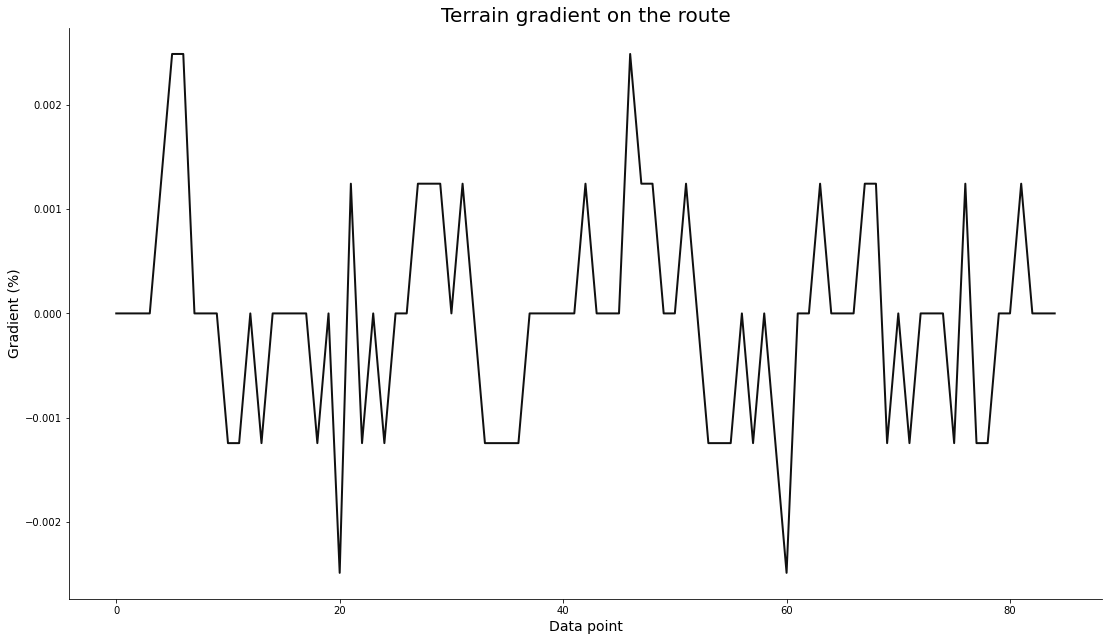

In [90]:


plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient)), gradient, lw=2, color='#101010');

In [91]:
mile_marker_loc(df)

[454, 912, 1464, 2017, 2618, 3163, 3647, 4124]

In [92]:
from folium.features import DivIcon

def number_DivIcon(color,number):
    """ Create a 'numbered' icon
    
    """
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
#             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
            html="""<span class="fa-stack " style="font-size: 12pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:02d}  
                    </strong>
                </span>""".format(color,number)
        )
    return icon
    
col_hex = ['#440154',
 '#481a6c',
 '#472f7d',
 '#414487',
 '#39568c',
 '#31688e',
 '#2a788e',
 '#23888e',
 '#1f988b',
 '#22a884',
 '#35b779',
 '#54c568',
 '#7ad151',
 '#a5db36',
 '#d2e21b']

In [93]:
route_map = folium.Map(
    location=[38.778, -77.05],
    zoom_start=14,
    tiles='OpenStreetMap',
    width= 600,
    height=600
)
coordinates = [tuple(x) for x in df[['latitude','longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

locations_to_chart = mile_marker_loc(df)
mile_times = run_miles(df)
num =0
mile=1
for i in locations_to_chart:
    loc = [df['latitude'][i], df['longitude'][i]]
    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon=folium.Icon(color='white',icon_color='white'),
        markerColor=col_hex[mile]
    ).add_to(route_map)

    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile)+ " "+ mile_times[mile-1],
        icon= number_DivIcon(col_hex[mile],mile)
    ).add_to(route_map)
    mile+=1



display(route_map)

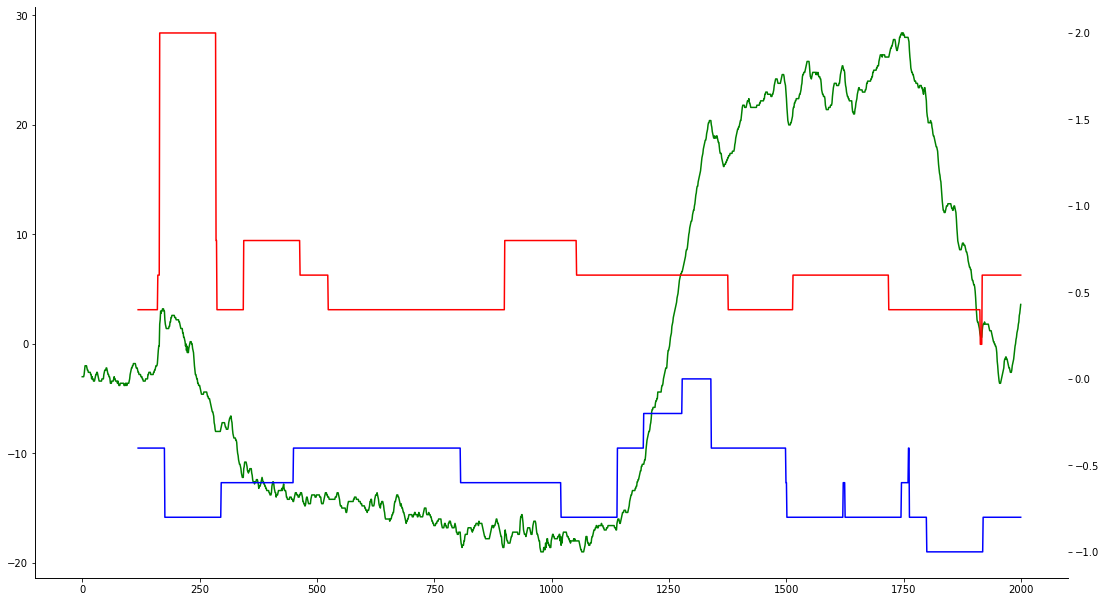

In [94]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')



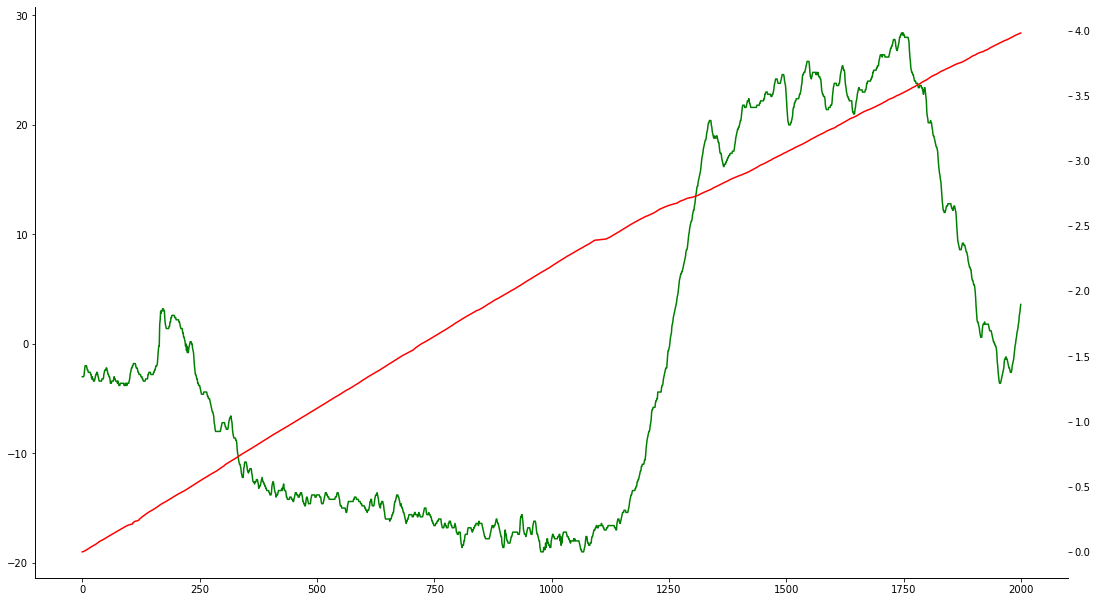

In [95]:
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['cum_distance'][0:2000], c='r')

In [96]:
df.to_csv('data/df_mile.csv', index=False)
df.head()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time,mile_num,grade_section
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,0,0:00:00,0.000000,0,1.0,1.0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,0.000400,1.440858,0.0,0.0,0.000400,NaN,1,0:00:01,2.113258,1,1.0,1.0
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,0.001189,4.277103,0.0,0.0,0.001590,NaN,2,0:00:02,6.273084,1,1.0,1.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,0.001182,4.249086,0.0,0.0,0.002771,NaN,3,0:00:03,6.231993,1,1.0,1.0
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,0.002062,7.422258,0.2,0.2,0.004833,0.04,4,0:00:04,10.885979,1,1.0,1.0
